# Numerical Solutions to Ordinary Differential Equations

Since almost all second order or higher differential equations do not have an analytical solution, we have to resort to numerical techniques to solve these equations. This notebook is a short introduction on how to go about solving these equations.  
This notebook assumes you are comfortable with ODEs as mathematical concepts and are not a complete beginner to Python. There will also be a version of this notebook in Julia.

## 1- Solvers in Python

The *scipy.integrate* library has a powerful Initial value problem solver called *solve\_ivp*. You can look up the full documentation here: https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html#scipy.integrate.solve_ivp

This is the only solver you need to know about for initial value problems because it is extremely flexible; You can specify the method you want it to use. The supported methods are:


- ‘RK45’ (default): Explicit Runge-Kutta method of order 5(4). Can be applied in the complex domain.
- ‘RK23’: Explicit Runge-Kutta method of order 3(2). Can be applied in the complex domain.
- ‘DOP853’: Explicit Runge-Kutta method of order 8. Can be applied in the complex domain.
- ‘Radau’: Implicit Runge-Kutta method of the Radau IIA family of order 5.
- ‘BDF’: Implicit multi-step variable-order (1 to 5) method based on a backward differentiation formula for the derivative approximation. Can be applied in the complex domain.
- ‘LSODA’: Adams/BDF method with automatic stiffness detection and switching. This is a wrapper of the Fortran solver from ODEPACK.
  
Explicit Runge-Kutta methods (‘RK23’, ‘RK45’, ‘DOP853’) should be used for non-stiff problems and implicit methods (‘Radau’, ‘BDF’) for stiff problems. Among Runge-Kutta methods, ‘DOP853’ is recommended for solving with high precision. ‘LSODA’ can also be a good universal choice, but it might be somewhat less convenient to work with as it wraps old Fortran code. 
Personally, I use 'LSODA' the most. Read the above linked documentation for more details.  
For Boundary Value Problems there is a similar solver called *solve_bvp* but BVPs are much less commonly used.


## 2- Error Tolerance

Since an exact solution for most ODEs does not exist and we have to numerically compute the solution at some discretized steps, keeping an eye on error tolerance becomes very important. Each solver algorithm has a specified error rating which sets bounds on its accuracy.  
- If you want high accuracy you should use a higher order algorithm and should take smaller time steps. Obviously, this has a high computational cost.  
- Similarly, if your equation has parameters spanning a range of values, you should try to scale them so there isn't an overflow or underflow somewhere in your code. For example if you have an equation where one parameter has a value 1e-34 and another parameter with value 1e16, the solver will have to  work harder to keep the error within the error bounds (or might even outright fail to converge to  a solution). There is also a risk that doing operations on these numbers (like exponentiation or dividing by its square) might lead to overflow or underflow. 
- It is important to realize there is no one best algorithm for numerically solving ODEs. There are hundreds of algorithms and most of them are designed keeping in mind one kind of system. For example, there is a class of solvers called 'Symplectic' solvers which are most useful for numerical solution of Hamiltonian systems because they conserve the Hamiltonian (and thus the energy). These kinds of solvers are used by space agencies for orbital calculations, and are also useful for simulation of molecular dynamics because it is very important for these systems to conserve the total energy. 
- **Stiffness**: An ordinary differential equation problem is stiff if the solution being sought is varying slowly, but there are nearby solutions that vary rapidly, so the numerical method must take small steps to obtain satisfactory results. Stiffness is an efficiency issue. If we weren't concerned with how much time a computation takes, we wouldn't be concerned about stiffness. Nonstiff methods can solve stiff problems; they just take a long time to do it.  
Solutions? Adaptive step size and Stiff Solvers like the ones mentioned above.
-  Adaptive step size is a technique built into some solvers where it takes smaller time steps where the solution is changing rapidly and larger time steps where the solution is changing slowly. 

**Which solver should you use?**  
There is no one answer to that. You should start with general solvers like 'RK45'. You could use one of the stiff solvers as well just to check if it is giving a similar solution to the general solver. 'LSODA' is a good option because it has built in stiffness detection. It uses a different algorithm if the equation is stiff so you don't have to worry about that. It is also faster than others since it is orginally FORTRAN code.  
In any case you shouldn't worry too much about all this unless you are solving lots of differential equations at once or doing very long timescale integrations. 

## 3- First Order ODEs With One Variable

Let us start with the simplest kind of ODE. First order equation with one variable.  
Let's say, we want to solve the differential equation 

\begin{align*}
y'(t) = - ky + c
\end{align*}

with $k$ = 1.5, $c$ = 3 and initial condition $y(0) = 5$, on the interval $t$ = [0,15]


First, we rewrite the equation to:
\begin{align*}
y'(t) = f(t,y)
\end{align*}

where

\begin{align*}
f(t, y) = - ky + c
\end{align*}

We have now all the bits and pieces to do the numerical implementation. The syntax for solving ODEs using `solve_ivp` is the following:

```py
scipy.integrate.solve_ivp(fun, t_span, y0, method='RK45', t_eval=None, dense_output=False, events=None, vectorized=False, args=None, **options)
```

* fun: function that returns the derivative of $y$
* t_span: Interval of integration $[t_i, t_f]$
* y0: initial conditions e.q.  [0, -1] (which stands for $x(0) = 0$ and $\dot{x}(0) = -1$)
* method: The solver algorithm you want to use. Default algorithm is 'RK45'
* t_eval: Times at which to store the computed solution, must be sorted and lie within t_span.

You can read the documentation linked in section 1 to see what other options we have to control the solver.
The solver returns an object with some predefined fields explained in the documentation.

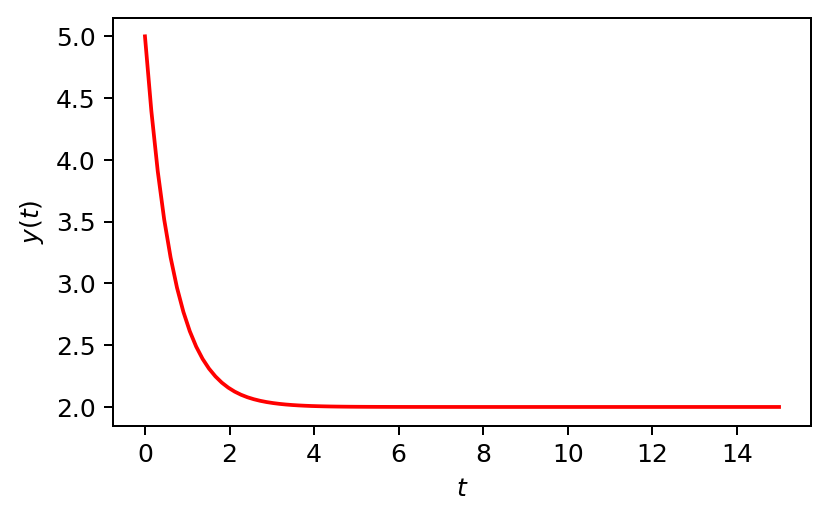

In [18]:
import numpy as np
import scipy.integrate as integrate
import matplotlib.pyplot as plt

# Initial parameters
ti  = 0.0
tf  = 15.0
k   = 1.5
c   = 3.0 
y_0 = 5   # Initial condition 
N   = 100 # Number of timesteps
t_eval = np.linspace(ti, tf, N) # Array of time steps

# Function that returns the rigt hand side of the ODE dy/dt = y'[t]
def f(t,y):
    dydt = -k*y + c
    return dydt

# Solving the ODE
solution = integrate.solve_ivp(f, [ti,tf], [y_0], 'LSODA', t_eval)

# Extracting variables from solution object
t = solution.t
y = solution.y[0]

# plot results
fig = plt.figure(figsize=(5,3), dpi =180)
plt.plot(t, y, 'r')
plt.xlabel(r'$t$')
plt.ylabel(r'$y(t)$')
plt.show()

### Exercise 1

We want to solve the following equation from $t=0$ to $t=\infty$:
\begin{equation}
    \frac{dx}{dt} = \frac{1}{x^2 + t^2}  \;\;\;\text{,}\;\;\; x(t=0) = 1
\end{equation}

Hint: Don't go ahead solving this for infinite time. Use a change of variable for $t$.  
Solution at the end 

In [19]:
# Your solution here


## Coupled First Order ODEs  

Now we look at simultaneous differential equations. Fortunately, they are not much different to solve than the ones we have already seen. 
Let's look at the Lorenz system which is specified by the following equations:  
\begin{align}
\frac{\mathrm{d}x}{\mathrm{d}t} &= \sigma (y - x), \\[6pt]
\frac{\mathrm{d}y}{\mathrm{d}t} &= x (\rho - z) - y, \\[6pt]
\frac{\mathrm{d}z}{\mathrm{d}t} &= x y - \beta z.
\end{align}  

For special values of $\sigma$,$\rho$, and $\beta$ this system exhibits chaotic behaviour. Let's try solving this system and compare the outputs with slightly different initial conditions.

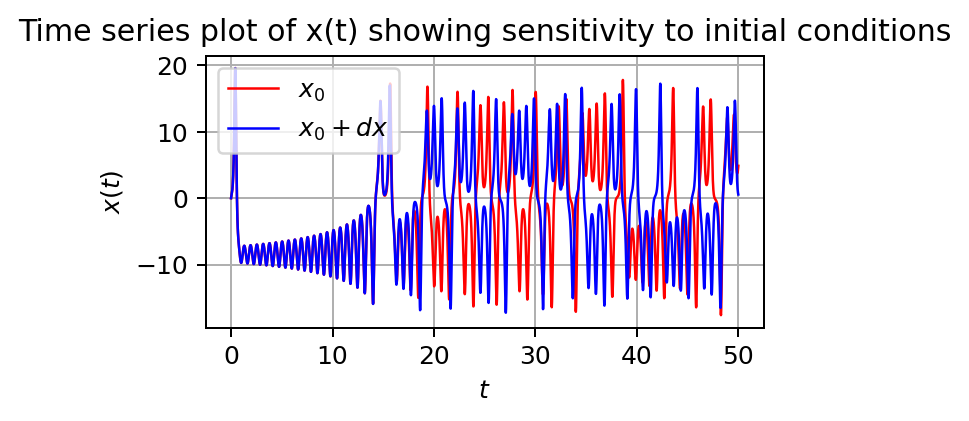

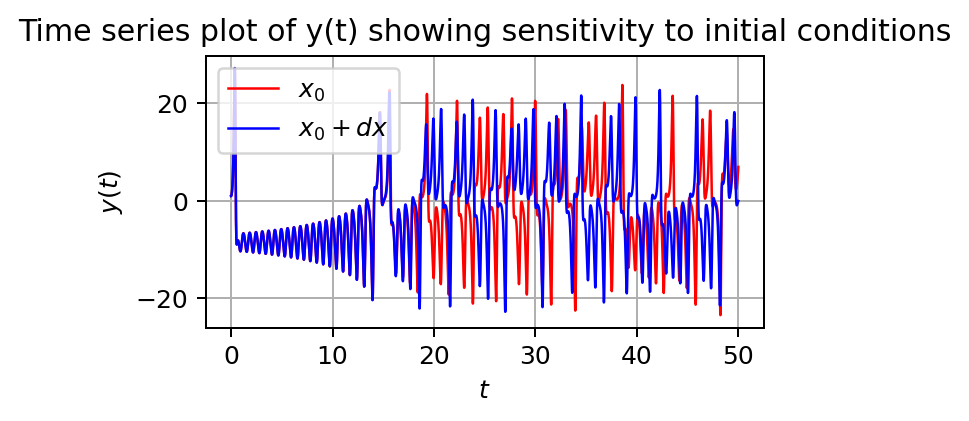

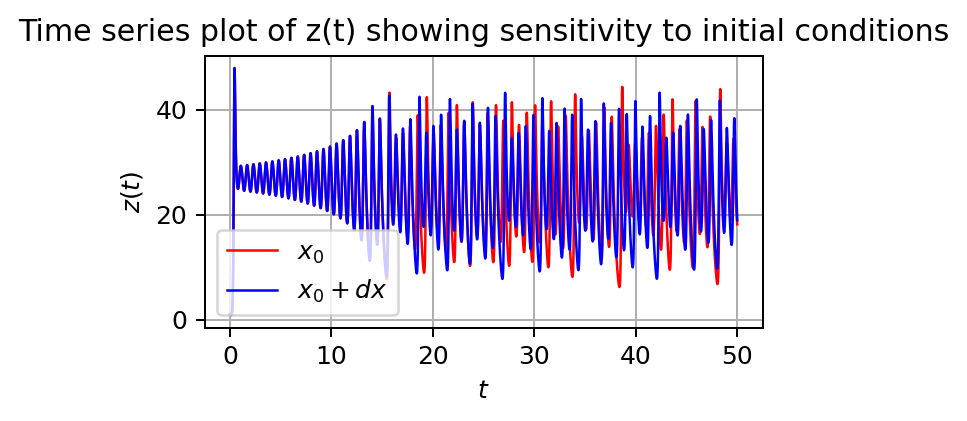

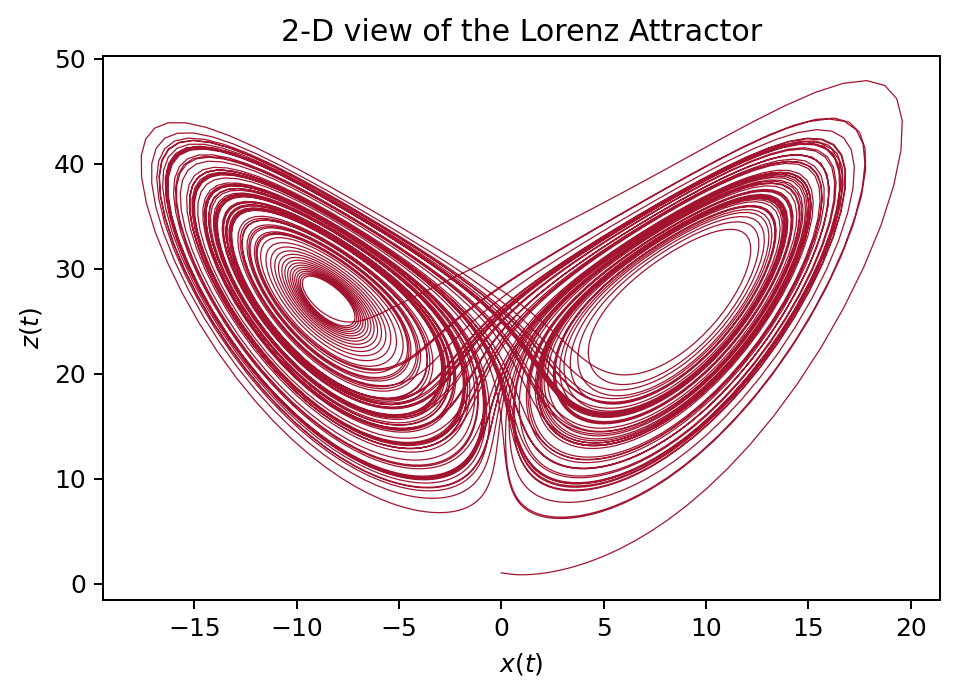

In [57]:
# Lorenz system

import numpy as np
import scipy.integrate as integrate
import matplotlib.pyplot as plt

# We have made the whole solver into a function so that we can just specify the initial values and get the solution.

def Lorenz_solver(x0,y0,z0,t):
    
    sigma, beta, rho = 10, 2.667, 28
    
    # This is the actual derivative function (i.e. the RHS of the system). Note that instead of using f(t,y) we have used 
    # f(t, r) where r is a vector with components x,y,z
    
    def Lorenz(t,r): 
        x = r[0]
        y = r[1]
        z = r[2]
        dx = -sigma * (x - y)
        dy = rho * x - y - x * z
        dz = -beta * z + x * y
        return np.array([dx, dy, dz])

    y0 = np.array([x0,y0,z0]) # Initial condition vector

    sol = integrate.solve_ivp(Lorenz, [t[0],t[-1]], y0, method='LSODA', t_eval=t, rtol = 1e-6)

    u = np.array([sol.y[0],sol.y[1],sol.y[2]])
    
    return u

# Now we call the function for whatever initial conditions we choose
x0, y0, z0 = 0, 1, 1.05
t = np.linspace(0,100,10001)
u = Lorenz_solver(x0,y0,z0,t)
x = u[0,:]
y = u[1,:]
z = u[2,:]

# We are calling the solver function again but this time we have slightly changed the initial condition for one componenet
u1 = Lorenz_solver(x0+0.01,y0,z0,t)
x1 = u1[0,:]
y1 = u1[1,:]
z1 = u1[2,:]


# Now we plot the solutions (This can be done compactly using subplots but here I do it differently for clarity)
fig = plt.figure(figsize=(4,2), dpi=180)
plt.plot(t[0:5000],x[0:5000],'r',label=r'$x_0$', lw=1)
plt.plot(t[0:5000],x1[0:5000],'b',label=r'$x_0+dx$', lw=1)
plt.title('Time series plot of x(t) showing sensitivity to initial conditions')
plt.xlabel(r'$t$')  
plt.ylabel(r'$x(t)$') 
plt.grid()
plt.legend()
plt.show()

fig = plt.figure(figsize=(4,2), dpi=180)
plt.plot(t[0:5000],y[0:5000],'r',label=r'$x_0$', lw=1)
plt.plot(t[0:5000],y1[0:5000],'b',label=r'$x_0+dx$', lw=1)
plt.title('Time series plot of y(t) showing sensitivity to initial conditions')
plt.xlabel(r'$t$')  
plt.ylabel(r'$y(t)$') 
plt.grid()
plt.legend()
plt.show()

fig = plt.figure(figsize=(4,2), dpi=180)
plt.plot(t[0:5000],z[0:5000],'r',label=r'$x_0$', lw=1)
plt.plot(t[0:5000],z1[0:5000],'b',label=r'$x_0+dx$', lw=1)
plt.title('Time series plot of z(t) showing sensitivity to initial conditions')
plt.xlabel(r'$t$')  
plt.ylabel(r'$z(t)$') 
plt.grid()
plt.legend()
plt.show()

fig = plt.figure(figsize=(6,4), dpi=180)
plt.plot(x,z,'#A2142F',lw=0.5)
plt.title('2-D view of the Lorenz Attractor')
plt.xlabel(r'$x(t)$')  
plt.ylabel(r'$z(t)$') 
plt.show()

Since these equations are coupled and chaotic, a slight change in the initial conditions of one component changes the trajectory of all components drastically.

### Exercise 2:  
We already know that Ordinary Differential Equations can be used to model a wide variety of physical systems. Let's look at a couple of predator-prey models. The simplest predator-prey model is the Lotka-Volterra model (https://en.wikipedia.org/wiki/Lotka%E2%80%93Volterra_equations) which we learned in our differential equations course. It is not a particularly stable model and is unable to cope with perturbations which might arise in an ecosystem. There is another model called the Holling-Tanner Model which is given by the following set of equations:  

\begin{equation}
\frac{dx}{dt} = cx(1-\frac{x}{k}) - q\frac{xy}{a+x}
\end{equation}
\begin{equation}
\frac{dy}{dt} = sy(1-\frac{Ny}{x})
\end{equation}  
Your job is to solve this system and determine whether or not this model is stable to perturbations. Remember that for a model to be stable it should form a closed loop in phase space ( which means the system should eventually return to that loop even if it is perturbed). Phase space can be viewed as y-x plot for this problem. The constants are defined in the code box below.


In [ ]:
# Your solution here 

# ----------- [User Params]
c = 1
k = 7
q = 6/7
a = 1
s = 0.2
N_m = 0.5
# --- Initial Conditions
x0 = 7.0       # initial prey pop. size
y0 = 0.1       # initial predator pop. size
# --- time params
ti = 0         # start time
tf = 200        # end time
N = 3000;      # num of time points to use

# -----------

## Second Order ODE with One Variable   

To solve differential equations of higher order than one, we have to rewrite the differential of order $n$ as a system of $n$ first order differential equations. 

Suppose that we want to solve the following second order ODE

\begin{equation*}
x''(t) = x'(t) + x(t)
\end{equation*}

we can use $x'(t) = v(t)$ to rewrite the equations in the following form:
\begin{align*}
x'(t) &= v(t) \\
v'(t) &= v(t) + x(t)\,.
\end{align*}

With this in mind, we can rewrite the coupled differential equation to the form

\begin{align*}
y'(t) = f(t, y)
\end{align*}

where

$$
y(t) = 
\left(\begin{array}{cc} 
x(t) \\ 
v(t)
\end{array}\right)
$$ 
and
$$
f(t,y) = 
\left(\begin{array}{cc} 
v(t) \\
 v(t) + x(t)
\end{array}\right)
$$

### Example:  
Suppose want to solve a classical damped harmonic oscillator.

\begin{align*}
\frac{d^2\theta}{dt^2} &= - \frac{b}{m}\frac{d\theta}{dt} - \frac{g}{l} sin(\theta)
\end{align*}  
for $\theta(0) = \pi/4$ and $\dot{\theta}(0) = 0$

We can split this into two first order coupled equations: 
\begin{align*}
\theta'(t) &= \omega(t) \\
\omega'(t) &= -\frac{b}{m}\omega - \frac{g}{l} sin(\theta) \,
\end{align*}  
We already know how to solve coupled first order ODEs.




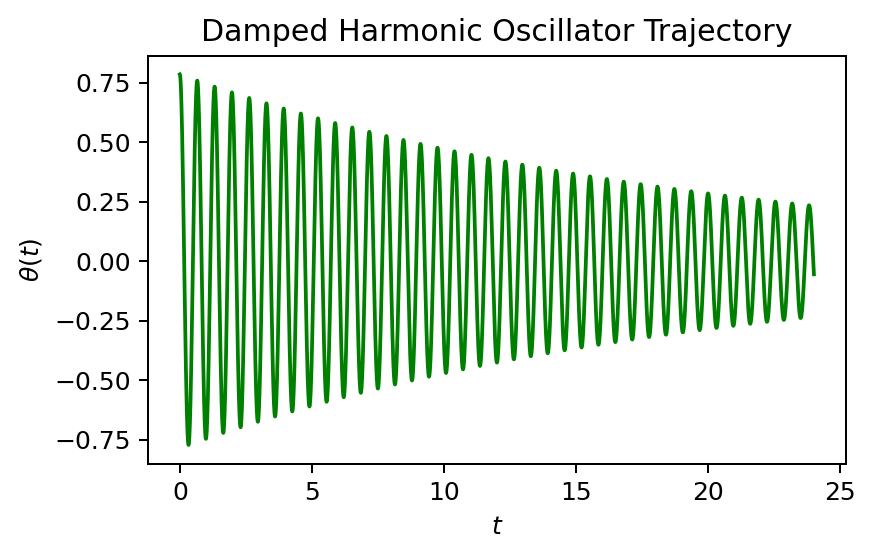

In [128]:
# Damped Harmonic Oscillator

import numpy as np
import scipy.integrate as integrate
import matplotlib.pyplot as plt

# ----------- [User Params]
# ----parameters
g = 9.81 #[ms^-2]
l = 0.1  #[m]
b = 0.05 #damping coefficient
m = 0.5  #[kg] 
# ----time params
ti = 0
tf = 24
N  = 5000
t_eval  = np.linspace(ti,tf,N) 

# ----- ICs
theta_0 = np.pi/4
omega_0 = 0.0
y_0 = [theta_0, omega_0]


def Pendulum(t,r): 
    theta = r[0]
    omega = r[1]
    d_theta = omega
    d_omega = -(b/m)*omega -(g/l)*np.sin(theta)
    return np.array([d_theta, d_omega])

# Solving the ODE
solution = integrate.solve_ivp(Pendulum, [ti,tf], y_0, 'LSODA', t_eval, rtol = 1e-6)

# Extracting variables from solution object
theta = solution.y[0]
omega = solution.y[1]


# plot results
fig = plt.figure(figsize=(5,3), dpi =180)
plt.plot(t_eval, theta, 'g')
plt.xlabel(r'$t$')
plt.ylabel(r'$\theta(t)$')
plt.title("Damped Harmonic Oscillator Trajectory")
plt.show()

## Coupled Second Order ODEs  

Let's now look at how we can solve systems of differential equations with order higher than 1. 
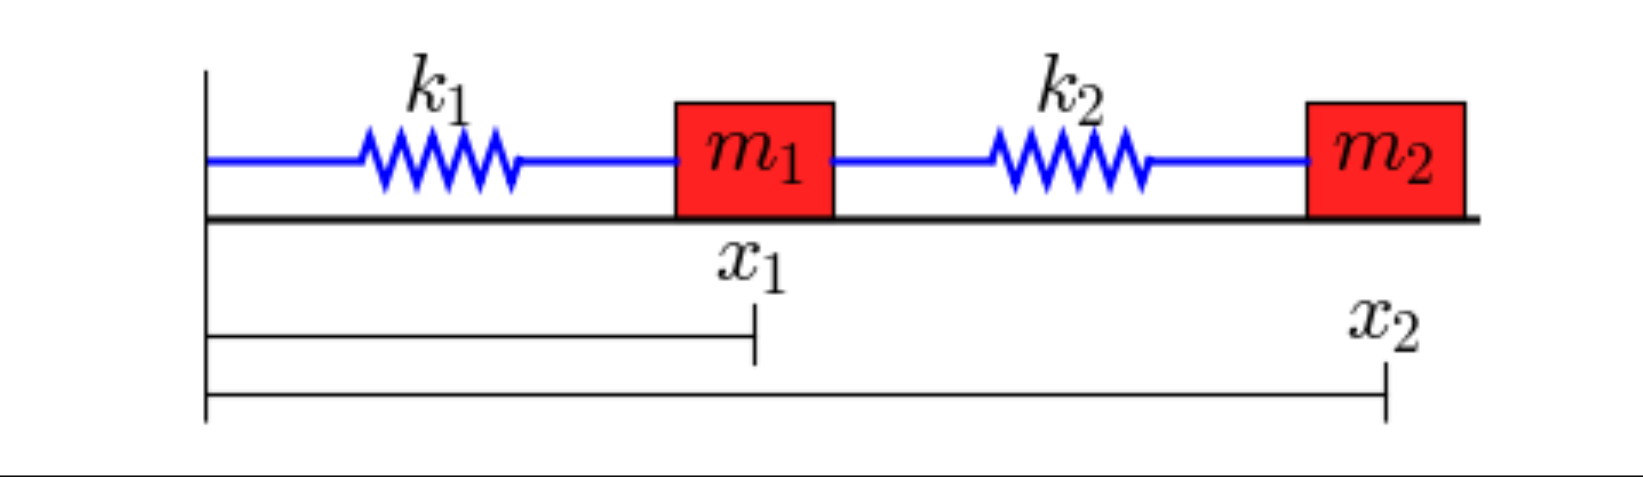

Let's imagine a damped mass-spring system like the one shown in the image above. This system can be described by the following coupled differential equations:

\begin{align*}
\frac{d^2x_1}{dt^2} + \frac{b_1}{m_1}\frac{dx_1}{dt} + \frac{k_1}{m_1}(x_1(t) - d_1) - \frac{k_2}{m_1}(x_2(t) - x_1(t) - d_2) &= 0 \\
\frac{d^2x_2}{dt^2} + \frac{b_2}{m_2}\frac{dx_2}{dt} + \frac{k_2}{m_2}(x_2(t) - x_1(t) - d_2)  &= 0
\end{align*}

We write these two second order differential equations as 4 first order differential equations by defining $v_1 = x'_1$ and $v_2 = x'_2$:  

\begin{align*}
x_1'(t) &= v_1(t) \\
x_2'(t) &= v_2(t) \\
v_1'(t) &= - \frac{b_1}{m_1}v_1 - \frac{k_1}{m_1}(x_1(t) - d_1) + \frac{k_2}{m_1}(x_2(t) - x_1(t) - d_2) \\
v_2'(t) &= -\frac{b_2}{m_2}v_2 - \frac{k_2}{m_2}(x_2(t) - x_1(t) - d_2)
\end{align*}


Now let's solve this system of differential equations.

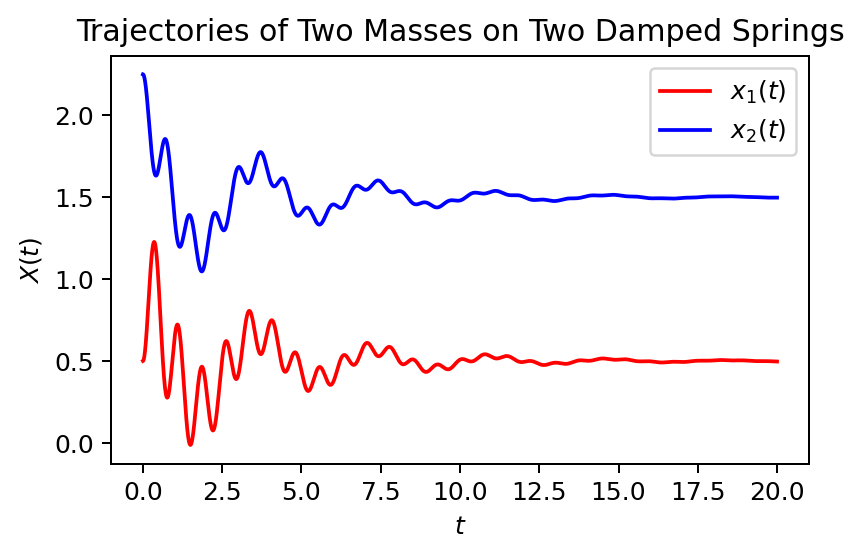

In [223]:
# Damped Mass-Spring System

import numpy as np
import scipy.integrate as integrate
import matplotlib.pyplot as plt

# ----------- [User Params]
# Masses:
m1 = 1.0
m2 = 1.5
# Spring constants
k1 = 8.0
k2 = 40.0
# Natural lengths
d1 = 0.5
d2 = 1.0
# Friction coefficients
b1 = 0.8
b2 = 0.5
# ----time params
ti = 0.0
tf = 20.0
N  = 5000
t_eval  = np.linspace(ti,tf,N) 

# ----- Initial Conditions
x1_0 = 0.5
x2_0 = 2.25
v1_0 = 0.0
v2_0 = 0.0
y_0 = [x1_0, x2_0, v1_0, v2_0]


def Mass_Spring(t,r): 
    x1 = r[0]
    x2 = r[1]
    v1 = r[2]
    v2 = r[3]
    d_x1 = v1
    d_x2 = v2
    d_v1 = -(b1/m1)*v1 - (k1/m1)*(x1-d1) + (k2/m1)*(x2-x1-d2)
    d_v2 = -(b2/m2)*v2 - (k2/m2)*(x2-x1-d2)
    return np.array([d_x1, d_x2, d_v1, d_v2])


# Solving the ODE
solution = integrate.solve_ivp(Mass_Spring, [ti,tf], y_0, 'LSODA', t_eval, rtol = 1e-6)

# Extracting variables from solution object
x1 = solution.y[0]
x2 = solution.y[1]
v1 = solution.y[2]
v2 = solution.y[3]


# plot results
fig = plt.figure(figsize=(5,3), dpi =180)
plt.plot(t_eval, x1, 'r', label=r'$x_1(t)$')
plt.plot(t_eval, x2, 'b', label=r'$x_2(t)$')
plt.xlabel(r'$t$')
plt.ylabel(r'$X(t)$')
plt.legend()
plt.title("Trajectories of Two Masses on Two Damped Springs")
plt.show()

### Example: 

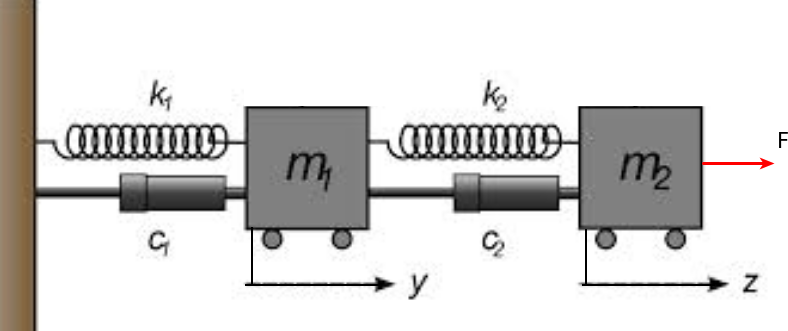  

Now, let's look at another damped mass spring system (as shown in above figure) but this time it is driven by an external force as well. This time we will solve it in a more sophisticated manner. This system has two masses but the method we use can be generalized to a system with $n$ masses. The equations of motion for this system are: 

\begin{align*}
x''_1 &=  \big(\frac{-c_1 - c_2}{m_1} \big)x'_1 + \big(\frac{c_2}{m_1} \big)x'_2 + \big(\frac{-k_1 - k_2}{m_1} \big)x_1 + \big(\frac{k_2}{m_1}\big)x_2 + \frac{F_1}{m_1} \\
x''_2 &= \big(\frac{c_2}{m_2}\big)x'_1 + \big(\frac{-c_2}{m_2}\big)x'_2 + \big(\frac{k_2}{m_2}\big)x_1 - \big(\frac{k_2}{m_2}\big)x_2 + \frac{F_2}{m_2} 
\end{align*}   

Let's convert this to a system of first order ODEs:  

\begin{align*}
x_1'(t) &= v_1(t) \\
x_2'(t) &= v_2(t) \\
v_1'(t) &= \big(\frac{-c_1 - c_2}{m_1} \big)v_1 + \big(\frac{c_2}{m_1} \big)v_2 + \big(\frac{-k_1 - k_2}{m_1} \big)x_1 + \big(\frac{k_2}{m_1}\big)x_2 + \frac{F_1}{m_1} \\
v_2'(t) &= \big(\frac{c_2}{m_2}\big)v_1 + \big(\frac{-c_2}{m_2}\big)v_2 + \big(\frac{k_2}{m_2}\big)x_1 - \big(\frac{k_2}{m_2}\big)x_2 + \frac{F_2}{m_2} 
\end{align*} 

We can be smart about this and write it as matrix equation of the form:  

$$\dot X = AX + F$$  

where  

$$\begin{align}
A &= \begin{bmatrix}0 & 0 & 1 & 0 \\ 0 & 0 & 0 & 1 \\ \big(\frac{-k_1 - k_2}{m_1} \big) & \big(\frac{k_2}{m_1}\big) & \big(\frac{-c_1 - c_2}{m_1} \big) & \big(\frac{c_2}{m_1} \big) \\ \big(\frac{k_2}{m_2}\big) & \big(\frac{-k_2}{m_2}\big) & \big(\frac{c_2}{m_2}\big) & \big(\frac{-c_2}{m_2}\big) \\ \end{bmatrix} \\[6pt]
F &= \begin{bmatrix}0 \\ 0 \\  \frac{F_1}{m_1} \\ \frac{F_2}{m_2} \\ \end{bmatrix} \\[6pt]
X &= \begin{bmatrix}x_1 \\ x_2 \\ v_1 \\ v_2 \end{bmatrix}
\end{align}$$

Suppose $F_1$=0 and $F_2 = F_0 cos(\omega t)$


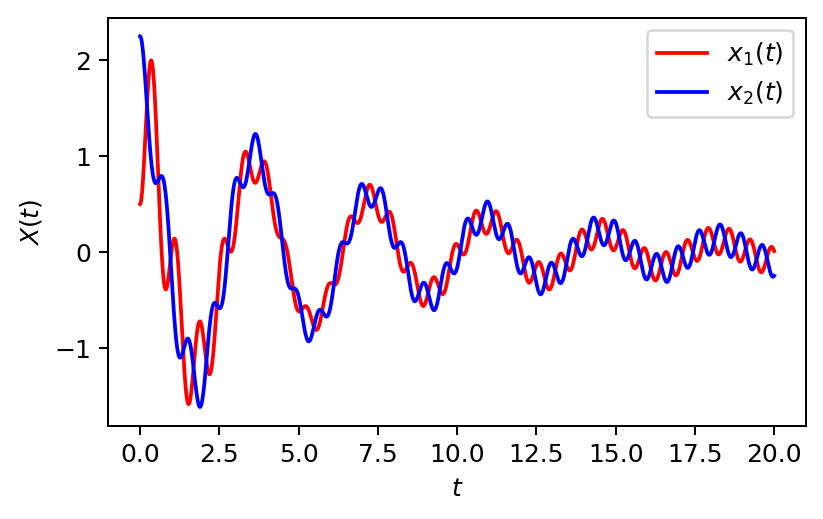

In [212]:
# Mass_Spring_Matrix

import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# ----------- [User Params]
# Masses:
m1 = 1.0
m2 = 1.5
# Spring constants
k1 = 8.0
k2 = 40.0
# Friction coefficients
c1 = 0.8
c2 = 0.5
# Force parameters
omega = 3*np.pi
F_0 = 10
# ----time params
ti = 0.0
tf = 20.0
N  = 5000
t_eval  = np.linspace(ti,tf,N) 

# ----- Initial Conditions
x1_0 = 0.5
x2_0 = 2.25
v1_0 = 0.0
v2_0 = 0.0
y_0 = [x1_0, x2_0, v1_0, v2_0]

A = np.array([[0, 0, 1, 0],
              [0, 0, 0, 1],
              [(-k1-k2)/m1, k2/m1, (-c1-c2)/m1, c2/m1],
              [k2/m2, -k2/m2, c2/m2, -c2/m2]])


def Mass_Spring_2(t, x):
    F = np.array([0,0,0,(F_0/m2)*np.cos(omega*t)])
    return A.dot(x) + F


# Solving the ODE
solution = integrate.solve_ivp(Mass_Spring_2, [ti,tf], y_0, 'LSODA', t_eval, rtol = 1e-6)

# Extracting variables from solution object
x1 = solution.y[0]
x2 = solution.y[1]
v1 = solution.y[2]
v2 = solution.y[3]


# plot results
fig = plt.figure(figsize=(5,3), dpi =180)
plt.plot(t_eval, x1, 'r', label=r'$x_1(t)$')
plt.plot(t_eval, x2, 'b', label=r'$x_2(t)$')
plt.xlabel(r'$t$')
plt.ylabel(r'$X(t)$')
plt.legend()
plt.show()


### Exercise 3:   

A well known physical problem encountered in Classical Mechanics courses is the double pendulum. The system is defined by the following coupled equations of motion:  

\begin{align*}
(m_1 + m_2)l_1 \ddot{\theta}_1 + m_2l_2\ddot{\theta}_2\cos(\theta_1 - \theta_2) + m_2l_2\dot{\theta}_2^2\sin(\theta_1 - \theta_2) + (m_1+m_2)g\sin\theta_1 &= 0,\\
m_2l_2\ddot{\theta}_2 + m_2l_1\ddot{\theta}_1\cos(\theta_1 - \theta_2) - m_2l_1\dot{\theta}_1^2\sin(\theta_1 - \theta_2) + m_2g\sin\theta_2 = 0.
\end{align*}  

Changing this to a system of first order ODEs we get the following  equations:  

\begin{align*}
\dot{\theta}_1 &= \omega_1 \\
\dot{\theta}_2 &= \omega_2 \\
\dot{\omega}_1 &= \frac{m_2g\sin\theta_2\cos(\theta_1-\theta_2) - m_2\sin(\theta_1 - \theta_2)[l_1z_1^2\cos(\theta_1 - \theta_2) + l_2z_2^2] - (m_1+m_2)g\sin\theta_1}{l_1[m_1 + m_2\sin^2(\theta_1-\theta_2)]}\\
\dot{\omega}_2 &= \frac{(m_1+m_2)[l_1z_1^2\sin(\theta_1-\theta_2) - g\sin\theta_2 + g\sin\theta_1\cos(\theta_1-\theta_2)]+m_2l_2z_2^2\sin(\theta_1-\theta_2)\cos(\theta_1-\theta_2)}{l_2[m_1 + m_2\sin^2(\theta_1-\theta_2)]}
\end{align*}  

Solve these equations numerically. Plot the trajectories and the phase space diagram.

In [222]:
# Your solution here  

# ----------- [User Params]
# --- parameters
l1 = 1
l2 = 1
m1 = 1
m2 = 1
g = 9.81

# --- ICs
theta1_0 = (1/4)*np.pi      
theta2_0 = (3/7)*np.pi 
omega1_0 = 0.0
omega2_0 = 0.0
y_0 = [theta1_0, theta2_0, omega1_0, omega2_0]

# --- time params
ti = 0         # start time
tf = 50        # end time
N  = 5000;     # num of time points to use
t_eval  = np.linspace(ti,tf,N)

## Solutions to Exercises

### Exercise 1 solution:  

if we want to find the solution all the way out to $t$ = $\infty$ instead of a finite time? We can obviously not compute infinite time steps but we can use a clever change of variable:  
\begin{equation}
    u = \frac{t}{1+t}\;\;\;\; \text{ or equivalently }\;\;\;\; t = \frac{u}{1-u}
\end{equation}  

such that as $t\to \infty$ we have $u\to 1$. Now using chain rule we find:

\begin{equation}
    \frac{dx}{du} = (1-u)^{-2} \;\;f\left(x,\frac{u}{1-u}\right)
\end{equation}  

which is a normal first-order differential equation again, as before. Solving this
equation for values of $u$ up to 1 is equivalent to solving the original equation
for values of $t$ up to $\infty$.

Using the last equation we can write our original equation as  

\begin{equation}
    \frac{dx}{du} = \frac{1}{x^2(1-u)^2 + u^2}\;\;\;\text{,}\;\;\; x(u=0) = 1
\end{equation}  
from $u=0\;\;$ to $\;\;u=1$


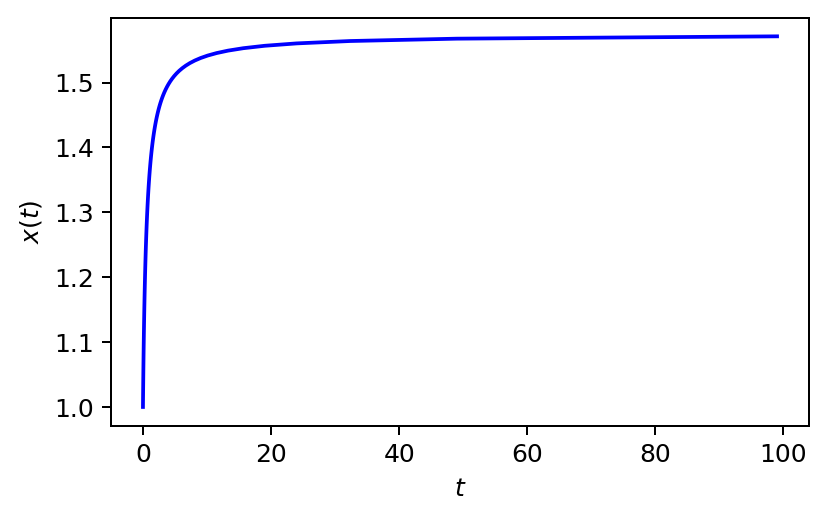

In [138]:
# Solution Exercise 1

import numpy as np
import scipy.integrate as integrate
import matplotlib.pyplot as plt

# Initial parameters
ui  = 0.0
uf  = 1
x_0 = 1   # Initial condition 
N   = 100 # Number of timesteps
u_eval = np.arange(ui,uf,(uf-ui)/N) # Array of time steps


# Defining the equation
def g(x,u):
    return 1/(x**2 *(1-u)**2+u**2)

# Solving the ODE
solution = integrate.solve_ivp(g, [ui,uf], [x_0], 'LSODA', u_eval, rtol=1e-6)

# Extracting variables from solution object
u = solution.t
t = u/(1-u)     # changing back from u to t
x = solution.y[0]

# plot results
fig = plt.figure(figsize=(5,3), dpi =180)
plt.plot(t, x, 'b')
plt.xlabel(r'$t$')
plt.ylabel(r'$x(t)$')
plt.show()


### Exercise 2 solution:  

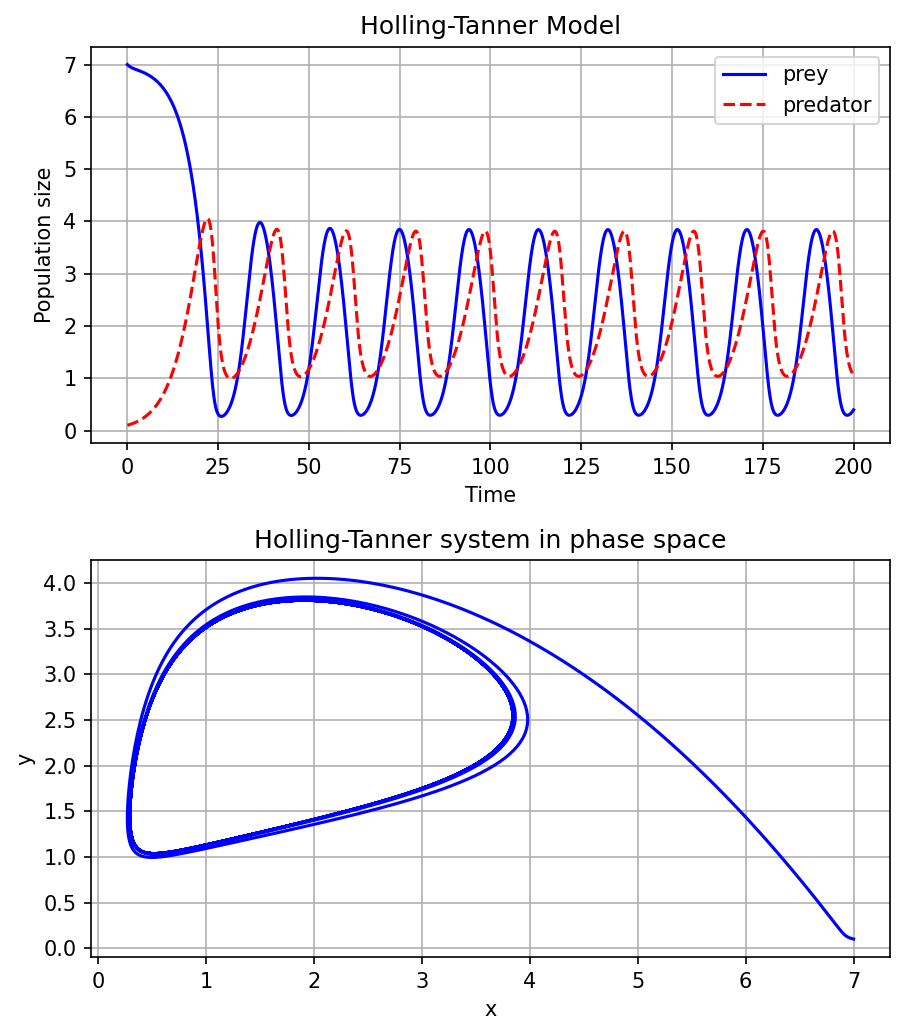

In [70]:
## Holling-Tanner Model

import numpy as np
import scipy.integrate as integrate
import matplotlib.pyplot as plt

# ----------- [User Params]
# --- parameters
c = 1
k = 7
q = 6/7
a = 1
s = 0.2
N_m = 0.5
# --- ICs
x0 = 7.0       # initial prey pop. size
y0 = 0.1       # initial predator pop. size
# --- time params
ti = 0         # start time
tf = 200        # end time
N = 3000;      # num of time points to use

# -----------

# ----------- [define ODE system]
def Holling_Tanner(t,r):
    x = r[0]
    y = r[1]
    fx = c*x*(1-x/k)-q*x*y/(a+x)
    fy = s*y*(1-N_m*y/x)
    return np.array([fx,fy],float)


t = np.linspace(ti,tf,N)   # time point array
y0 = [x0,y0]

sol = integrate.solve_ivp(Holling_Tanner, [t[0],t[-1]], y0, method='RK45', t_eval=t, rtol = 1e-6)

u = np.array([sol.y[0],sol.y[1]])

x = u[0,:]
y = u[1,:]


fig = plt.figure(figsize=(6,7), dpi=150)
# --- visualize
# time waveforms
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
ax1.plot(t,x,'b-',label='prey')
ax1.plot(t,y,'r--',label='predator')
ax1.set_xlabel('Time')  
ax1.set_ylabel('Population size') 
ax1.set_title('Holling-Tanner Model')
ax1.grid()
ax1.legend()
# phase space
ax2.plot(x,y,'b-',label='X')
ax2.set_title('Holling-Tanner system in phase space')
ax2.set_xlabel('x')  
ax2.set_ylabel('y') 
ax2.grid()
plt.tight_layout()
plt.show()

### Exercise 3 solution:  

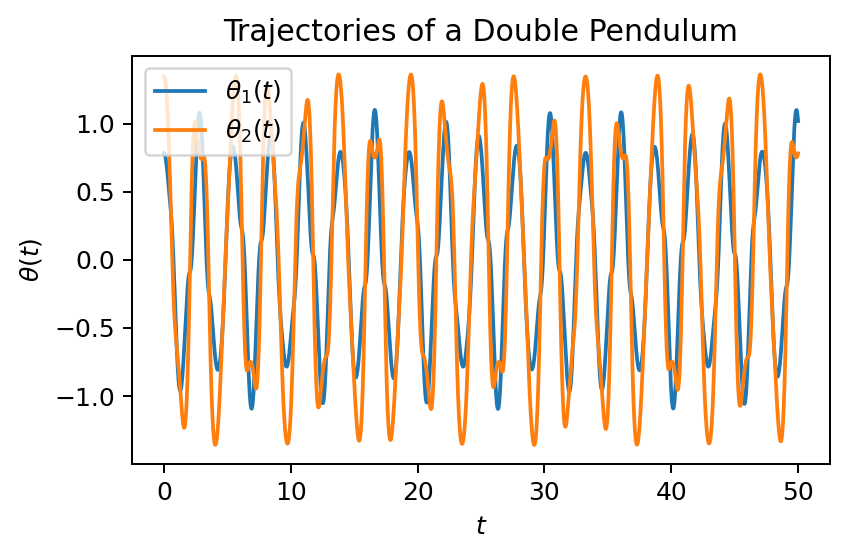

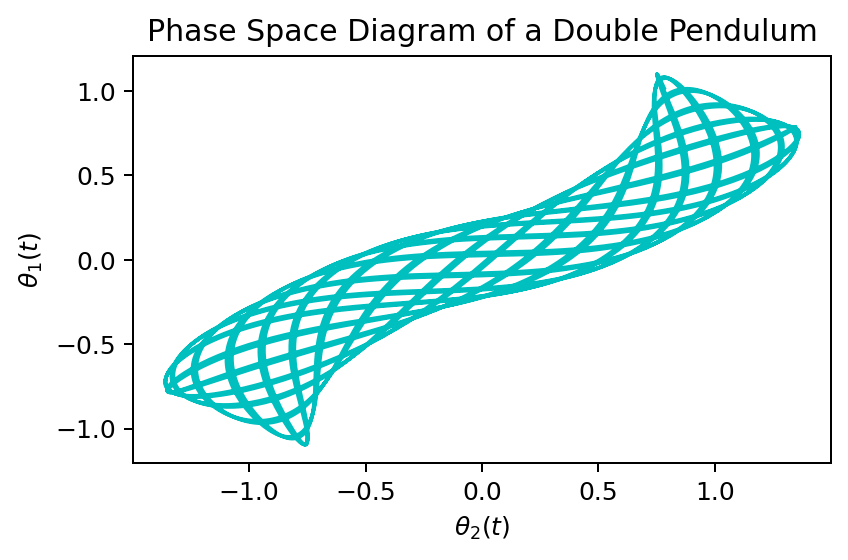

In [221]:
# Double Pendulum

import numpy as np
import scipy.integrate as integrate
import matplotlib.pyplot as plt

# ----------- [User Params]
# --- parameters
l1 = 1
l2 = 1
m1 = 1
m2 = 1
g = 9.81

# --- ICs
theta1_0 = (1/4)*np.pi      
theta2_0 = (3/7)*np.pi 
omega1_0 = 0.0
omega2_0 = 0.0
y_0 = [theta1_0, theta2_0, omega1_0, omega2_0]

# --- time params
ti = 0         # start time
tf = 50        # end time
N  = 5000;     # num of time points to use
t_eval  = np.linspace(ti,tf,N)

# -----------
def Double_Pendulum(t,r): 
    theta1 = r[0]
    theta2 = r[1]
    omega1 = r[2]
    omega2 = r[3]
    c = np.cos(theta1-theta2)
    s = np.sin(theta1-theta2)
    d_theta1 = omega1
    d_theta2 = omega2
    d_omega1 = (m2*g*np.sin(theta2)*c - m2*s*(l1*omega1**2*c + l2*omega2**2) - (m1+m2)*g*np.sin(theta1)) / l1 / (m1 + m2*s**2)
    d_omega2 = ((m1+m2)*(l1*omega1**2*s - g*np.sin(theta2) + g*np.sin(theta1)*c) + m2*l2*omega2**2*s*c) / l2 / (m1 + m2*s**2)
    return np.array([d_theta1, d_theta2, d_omega1, d_omega2])


# Solving the ODE
solution = integrate.solve_ivp(Double_Pendulum, [ti,tf], y_0, 'LSODA', t_eval, rtol = 1e-6)

# Extracting variables from solution object
theta1 = solution.y[0]
theta2 = solution.y[1]
omega1 = solution.y[2]
omega2 = solution.y[3]


# plot results
fig = plt.figure(figsize=(5,3), dpi =180)
plt.plot(t_eval, theta1, label=r'$\theta_1(t)$')
plt.plot(t_eval, theta2, label=r'$\theta_2(t)$')
plt.xlabel(r'$t$')
plt.ylabel(r'$\theta(t)$')
plt.legend()
plt.title("Trajectories of a Double Pendulum")
plt.show()


fig = plt.figure(figsize=(5,3), dpi =180)
plt.plot(theta2, theta1, 'c')
plt.xlabel(r'$\theta_2(t)$')
plt.ylabel(r'$\theta_1(t)$')

plt.title("Phase Space Diagram of a Double Pendulum")
plt.show()